In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from Utils.data_utils import load_CIFAR10, plot_images
%matplotlib inline
    
conf = tf.ConfigProto()
conf.gpu_options.per_process_gpu_memory_fraction = 0.2
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
plt.rcParams['figure.figsize']

[12.0, 6.0]

Data has already been downloaded and unpacked.
Train data shape (40000, 32, 32, 3)
Train labels shape (40000,)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000,)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000,)


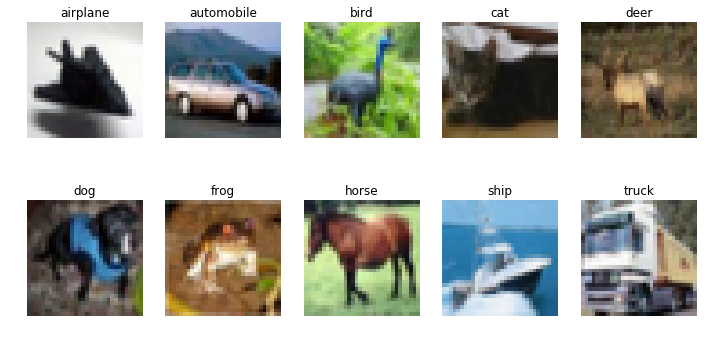

In [4]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, Class_names = load_CIFAR10()
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))
plot_images(X_train, Y_train, Class_names, Each_Category=True)

In [5]:
import functools
import numpy as np
import math

def lazy_property(function, name = None, *args, **kwargs):
    attribute = '_cache_' + function.__name__
    #name = scope or function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            #with tf.variable_scope(name, *args, **kwargs):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

def weight_variable(name, shape): # tf.truncated_normal: # Outputs random values from a truncated normal distribution. # values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
    initial = (tf.truncated_normal(shape, stddev=0.1)) 
    return tf.get_variable(name = name, shape = shape, initializer = tf.contrib.layers.xavier_initializer())

def bias_variable(name, shape):
    initial = tf.constant(np.array([0.1]))
    return tf.get_variable(name = name, initializer =initial)

def randomize(dataset, labels, batch_size):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_labels = labels[permutation]
    shuffled_labels = shuffled_labels[:batch_size]
    shuffled_dataset = dataset[permutation]
    shuffled_dataset = shuffled_dataset[:batch_size]
    return shuffled_dataset, shuffled_labels


In [6]:
def one_hot_encoding(labels):
    return (np.arange(10) == labels[:,None]).astype(np.float32)
    
Y_train = one_hot_encoding(Y_train)
Y_train = Y_train.reshape([-1,10])
Y_val = one_hot_encoding(Y_val)
Y_val = Y_val.reshape([-1,10])
Y_test = one_hot_encoding(Y_test)
Y_test = Y_test.reshape([-1,10])

In [17]:
# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
def run_model(session, model, X, Y, epochs=1, batch_size=500, is_training=False):
    # For training the model
    iterations = math.ceil(Y.shape[0] // batch_size)
    if is_training:
        for epoch in range(training_epochs):
            # data randomization (shuffle)
            permutation = np.random.permutation(Y.shape[0])
            shuffled_dataset = X[permutation,:,:,:]
            shuffled_labels = Y[permutation]
            time_sum = 0
            n_time = 0
            for step in range(iterations):
                offset = step * batch_size % (Y.shape[0] - batch_size)
                batch_x = shuffled_dataset[offset:offset+batch_size]
                batch_y = shuffled_labels[offset:offset+batch_size]
                feeds = {model.x : batch_x, model.y : batch_y, model.keep_probs : 0.5}
                start_train = time.time()
                session.run(model.optimize, feed_dict = feeds)
                time_sum += (time.time() - start_train)
                n_time += 1
                
                if(step % 10 == 0):
                    start_loss = time.time()
                    los, pred = session.run([model.loss, model.prediction], feed_dict = feeds)
                    acc = np.sum(np.equal(np.argmax(pred, axis=1), np.argmax(batch_y, axis=1)))
                    train_loss.append(los) # loss per batch_size
                    train_acc.append(acc / batch_size * 100)
                    print("epoch %d (iter %d/%d)\n   train_time: %.3f  loss_time: %.3f" 
                          % (epoch+1, step, iterations, time_sum/n_time, time.time() - start_loss))
                    time_sum = 0
                    n_time = 0
                    print("   train accuracy %.2f%%  train loss %.3f" 
                          % (acc / batch_size * 100, los))
                    
                    #"""
                    t_valid = time.time()
                    los, acc = run_model(session, model, X_val, Y_val)
                    valid_loss.append(los)
                    valid_acc.append(acc)
                    print("   valid time: %.3f" % (time.time() - t_valid))
                    print("   valid accuracy %.2f%%  valid loss %.3f" % (acc, los * batch_size))
                    #"""
                    
        print("Training done!")
    # Evaluate loss and accuracy of the model
    else:
        """
        print("Evaluation Start")
        feeds_test = {model.x : X, model.y : Y, model.keep_probs : 1}
        loss = session.run(model.loss, feed_dict = feeds_test)
        prediction = session.run(model.prediction, feed_dict = feeds_test)
        accuracy = 100.0 * np.sum(np.equal(np.argmax(prediction,axis=1), np.argmax(Y,axis=1))) / prediction.shape[0]
        print(accuracy)
        return (loss, accuracy)"""
        #return (loss / X.shape[0] * batch_size, accuracy / X.shape[0] * batch_size)
        ls = 0
        acc = 0
        for step in range(iterations):
            offset = step * batch_size % (Y.shape[0] - batch_size)
            batch_x = X[offset:offset+batch_size]
            batch_y = Y[offset:offset+batch_size]
            feeds = {model.x : batch_x, model.y : batch_y, model.keep_probs : 1}
            l, pred = session.run([model.loss, model.prediction], feed_dict = feeds)
            ls += l
            acc += np.sum(np.equal(np.argmax(pred, axis=1), np.argmax(batch_y, axis=1)))
            #tf.reduce_sum(tf.cast(tf.equal(tf.argmax(pred, axis=1), tf.argmax(batch_y, axis=1)),tf.float32))
        return (ls / X.shape[0], acc / X.shape[0] * 100) 

In [15]:
class my_model(object):
    def __init__(self):
        self.x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
        self.y = tf.placeholder(tf.float32, shape = [None, 10])
        self.keep_probs = tf.placeholder(tf.float32)
        
        self.logits
        self.loss
        self.optimize
        self.prediction

    @lazy_property
    def logits(self):
        initializer = tf.contrib.layers.xavier_initializer()
        # Conv & Pooling
        w1 = tf.Variable(initializer([3,3,3,16]))
        w2 = tf.Variable(initializer([3,3,16,16]))
        b1 = tf.Variable(tf.constant(0.01, shape=[16]))
        b2 = tf.Variable(tf.constant(0.01, shape=[16]))
        
        conv3_1 = tf.nn.conv2d(self.x, w1, strides=[1,1,1,1], padding='SAME') + b1
        conv3_2 = tf.nn.conv2d(conv3_1, w2, strides=[1,1,1,1], padding='SAME') + b2
        pool2_1 = tf.nn.max_pool(conv3_2, ksize = [1,2,2,1], strides = [1,2,2,1], padding='VALID')
        
        w3 = tf.Variable(initializer([3,3,16,32]))
        w4 = tf.Variable(initializer([3,3,32,32]))
        b3 = tf.Variable(tf.constant(0.01, shape=[32]))
        b4 = tf.Variable(tf.constant(0.01, shape=[32]))
        
        conv3_3 = tf.nn.conv2d(pool2_1, w3, strides=[1,1,1,1], padding='SAME')
        conv3_4 = tf.nn.conv2d(conv3_3, w4, strides=[1,1,1,1], padding='SAME')
        pool2_2 = tf.nn.max_pool(conv3_4, ksize = [1,2,2,1], strides = [1,2,2,1], padding='VALID')
        
        # Inception
        #incep = Inception_module(Input=l3, C1=5, C3_R=4, C3=5, C5_R=4, C5=5, P3_R=5)
        
        
        # FC layers
        fc0 = tf.reshape(pool2_2, [-1, 8*8*32])
        w5 = tf.Variable(initializer([8*8*32, 512]))
        b5 = tf.Variable(tf.constant(0.01, shape=[512]))
        w6 = tf.Variable(tf.truncated_normal([512, 10]), name = 'fc2_weight')
        b6 = tf.Variable(tf.constant(0.01, shape=[10]))
        
        fc1 = tf.matmul(fc0, w5) + b5
        fc1 = tf.nn.relu(fc1)
        self._logits = tf.matmul(fc1, w6) + b6
        return self._logits
    
    @lazy_property
    def loss(self):
        self._loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self._logits))
        return self._loss
    
    @lazy_property
    def prediction(self):
        output = tf.nn.softmax(logits=self._logits)
        return output
    
    @lazy_property
    def optimize(self):
        #optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01)
        optimizer = tf.train.AdamOptimizer(learning_rate = 0.001)
        return optimizer.minimize(self._loss)  

In [13]:
import signal

check_path = "CNN_model/model2"
def signal_handler(signal, frame):
    print("keyboard interrupt")
    saver = tf.train.Saver()
    saver.save(sess, check_path)
    print('Success save model')
    sys.exit(0)
    
signal.signal(signal.SIGINT, signal_handler)


import time
time_base = time.time()
tf.reset_default_graph()    

# Declare out simple model
print("Model Construct Start")
start_model = time.time()
model = my_model()
print("Model Construct Finished || time consumed : %.3f" % (time.time() - start_model))

# Hyperparamters
training_epochs = 5  
    
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    print("Train Start")
    run_model(sess, model, X_train, Y_train, epochs = training_epochs, is_training=True, reuse = True, path = check_path)
    print("Train Finish")
    t_train = time.time()
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f%%)" % run_model(sess, model, X_train, Y_train))
    print("Time for trainset loss/acc : %.3f" % (-t_train + time.time()))
    t_valid = time.time()
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f%%)" % run_model(sess, model, X_val, Y_val))
    print("Time for validset loss/acc : %.3f" % (-t_valid + time.time()))
    print("Total Time : %.3f" % (time.time() - time_base))
    
    saver = tf.train.Saver()
    saver.save(sess, check_path)
    

Model Construct Start
Model Construct Finished || time consumed : 10.109
Train Start
epoch 1 (iter 0/80)
   train_time: 23.493  loss_time: 0.588
   train accuracy 18.00%  train loss 11.272
   valid time: 10.691
   valid accuracy 15.21%  valid loss 12.389
epoch 1 (iter 10/80)
   train_time: 21.844  loss_time: 0.554
   train accuracy 28.00%  train loss 3.137
   valid time: 10.505
   valid accuracy 28.51%  valid loss 3.108
epoch 1 (iter 20/80)
   train_time: 22.591  loss_time: 0.540
   train accuracy 36.60%  train loss 1.966
   valid time: 10.385
   valid accuracy 32.81%  valid loss 2.046
epoch 1 (iter 30/80)
   train_time: 22.326  loss_time: 0.506
   train accuracy 37.60%  train loss 1.724
   valid time: 10.387
   valid accuracy 37.33%  valid loss 1.783
epoch 1 (iter 40/80)
   train_time: 22.044  loss_time: 0.574
   train accuracy 46.60%  train loss 1.652
   valid time: 10.627
   valid accuracy 42.75%  valid loss 1.658
epoch 1 (iter 50/80)
   train_time: 21.991  loss_time: 0.543
   train

NameError: name 'sys' is not defined

In [15]:
import os, sys
SAVER_DIR = "model"
checkpoint = os.path.join(SAVER_DIR, "model")
print(checkpoint)

model\model


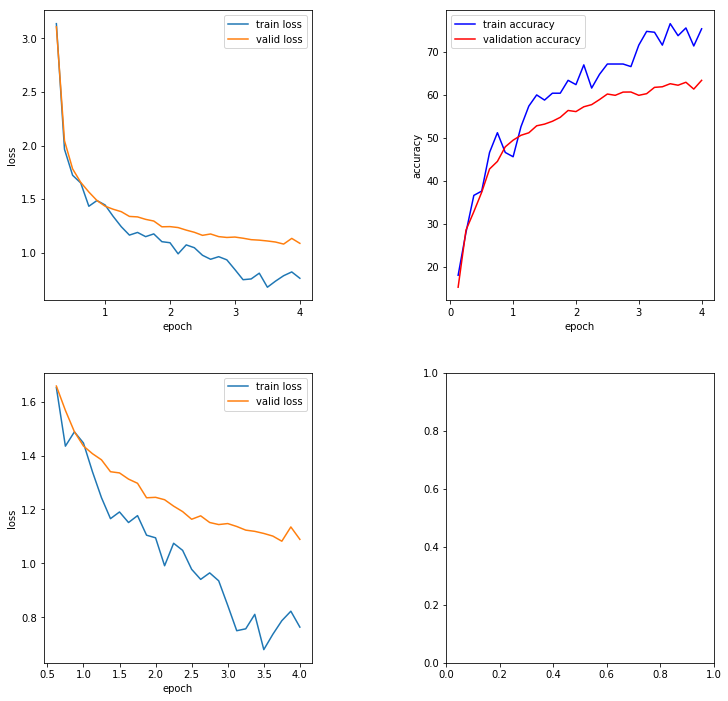

In [25]:
#### my_model3
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12.0, 12.0)

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
fig.subplots_adjust(hspace = 0.25, wspace = 0.5)

x = [ (i+1)/8 for i in range(32)]

valid_loss2 = [ i*500 for i in valid_loss]
ax1.plot(x[1:], train_loss[1:], label = 'train loss')
ax1.plot(x[1:], valid_loss2[1:], label = 'valid loss')
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()
#ax1.title("Losses over epochs")

ax3.plot(x[4:], train_loss[4:], label = 'train loss')
ax3.plot(x[4:], valid_loss2[4:], label = 'valid loss')
ax3.set_xlabel("epoch")
ax3.set_ylabel("loss")
ax3.legend()


train_acc2 = [ i/5 for i in train_acc]
ax2.plot(x, train_acc, c = 'blue', label = 'train accuracy')
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")

ax2.plot(x[:], valid_acc, c = 'red', label = 'validation accuracy')
ax2.legend()

plt.show()

## Save & Restore Model

In [20]:
import tfgraphviz as tfg
SAVER_DIR = "CNN_model/model1"

saver = tf.train.import_meta_graph(SAVER_DIR + ".meta")
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)

with tf.Session() as sess:
    saver = tf.train.import_meta_graph("./CNN_model/model1.meta")
    print(saver)
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, tf.train.latest_checkpoint('CNN_model'))
    
    graph = tf.get_default_graph()

    #list_name = [n.name for n in tf.get_default_graph().as_graph_def().node]
    #print(list_name)
    
    #loss = graph.get_tensor_by_name("Mean:0")
    x = graph.get_tensor_by_name("Placeholder:0")
    y = graph.get_tensor_by_name("Placeholder_1:0")
    drop = graph.get_tensor_by_name("Placeholder_2:0")
    #optimizer = graph.get_tensor_by_name("Adam:0")
    prediction = graph.get_tensor_by_name("Softmax:0")
    
    feeds = {x : X_val, y : Y_val, drop : 1}
    pred = sess.run(prediction, feed_dict = feeds)
    acc = np.sum(np.equal(np.argmax(pred, axis=1), np.argmax(Y_val, axis=1)))
    print("test accuracy : %f" % (acc / X_val.shape[0]))
    
    #if ckpt and ckpt.model_checkpoint_path:
        #saver.restore(sess, ckpt.model_checkpoint_path)
print("finish")

INFO:tensorflow:Restoring parameters from CNN_model\model1
test accuracy : 0.635900
finish


In [22]:
import signal

check_path = "CNN_model2/model"
def signal_handler(signal, frame):
    print("keyboard interrupt")
    saver = tf.train.Saver()
    saver.save(sess, check_path)
    print('Success save model')
    sys.exit(0)
    
signal.signal(signal.SIGINT, signal_handler)


import time
time_base = time.time()
tf.reset_default_graph()    

# Declare out simple model
print("Model Construct Start")
start_model = time.time()
model = my_model()
print("Model Construct Finished || time consumed : %.3f" % (time.time() - start_model))

# Hyperparamters
training_epochs = 5  
    
# Now, create a tf.Session and train the model
with tf.Session(config=conf) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver();
    saver.restore(sess, tf.train.latest_checkpoint('CNN_model'))
    print("Train Start")
    run_model(sess, model, X_train, Y_train, epochs = training_epochs, is_training=True)
    print("Train Finish")
    t_train = time.time()
    print("(Loss, Accuracy) on Training Dataset (%.4f, %.2f%%)" % run_model(sess, model, X_train, Y_train))
    print("Time for trainset loss/acc : %.3f" % (-t_train + time.time()))
    t_valid = time.time()
    print("(Loss, Accuracy) on Validataion Dataset (%.4f, %.2f%%)" % run_model(sess, model, X_val, Y_val))
    print("Time for validset loss/acc : %.3f" % (-t_valid + time.time()))
    print("Total Time : %.3f" % (time.time() - time_base))


Model Construct Start
Model Construct Finished || time consumed : 0.400
INFO:tensorflow:Restoring parameters from CNN_model\model1
Train Start
epoch 1 (iter 0/80)
   train_time: 23.375  loss_time: 0.602
   train accuracy 78.00%  train loss 0.694
   valid time: 10.436
   valid accuracy 62.75%  valid loss 1.099
epoch 1 (iter 10/80)
   train_time: 24.289  loss_time: 0.536
   train accuracy 78.20%  train loss 0.632
   valid time: 10.449
   valid accuracy 63.14%  valid loss 1.099
epoch 1 (iter 20/80)
   train_time: 22.687  loss_time: 0.536
   train accuracy 77.20%  train loss 0.640
   valid time: 10.800
   valid accuracy 63.74%  valid loss 1.080
keyboard interrupt
Success save model


NameError: name 'sys' is not defined

In [7]:
# Create a function to train and evaluata a model
# You can reuse this function throughout the assignment
train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
def run_pretrained_model(session, graph, X, Y, epochs=1, batch_size=500, is_training=False):
    # For training the model
    iterations = math.ceil(Y.shape[0] // batch_size)
    
    
    if is_training:
        for epoch in range(training_epochs):
            # data randomization (shuffle)
            permutation = np.random.permutation(Y.shape[0])
            shuffled_dataset = X[permutation,:,:,:]
            shuffled_labels = Y[permutation]
            time_sum = 0
            n_time = 0
            for step in range(iterations):
                offset = step * batch_size % (Y.shape[0] - batch_size)
                batch_x = shuffled_dataset[offset:offset+batch_size]
                batch_y = shuffled_labels[offset:offset+batch_size]
                feeds = {x : batch_x, y : batch_y, model.drop : 0.5}
                start_train = time.time()
                optimizer = graph.get_tensor_by_name("Adam:0")
                session.run(optimizer, feed_dict = feeds)
                time_sum += (time.time() - start_train)
                n_time += 1
                
                if(step % 10 == 0):
                    start_loss = time.time()
                    los, pred = session.run([model.loss, model.prediction], feed_dict = feeds)
                    acc = np.sum(np.equal(np.argmax(pred, axis=1), np.argmax(batch_y, axis=1)))
                    train_loss.append(los) # loss per batch_size
                    train_acc.append(acc / batch_size * 100)
                    print("epoch %d (iter %d/%d)\n   train_time: %.3f  loss_time: %.3f" 
                          % (epoch+1, step, iterations, time_sum/n_time, time.time() - start_loss))
                    time_sum = 0
                    n_time = 0
                    print("   train accuracy %.2f%%  train loss %.3f" 
                          % (acc / batch_size * 100, los))
                    
                    #"""
                    t_valid = time.time()
                    los, acc = run_model(session, model, X_val, Y_val)
                    valid_loss.append(los)
                    valid_acc.append(acc)
                    print("   valid time: %.3f" % (time.time() - t_valid))
                    print("   valid accuracy %.2f%%  valid loss %.3f" % (acc, los * batch_size))
                    #"""
                    
        print("Training done!")
    # Evaluate loss and accuracy of the model
    else:
        """
        print("Evaluation Start")
        feeds_test = {model.x : X, model.y : Y, model.keep_probs : 1}
        loss = session.run(model.loss, feed_dict = feeds_test)
        prediction = session.run(model.prediction, feed_dict = feeds_test)
        accuracy = 100.0 * np.sum(np.equal(np.argmax(prediction,axis=1), np.argmax(Y,axis=1))) / prediction.shape[0]
        print(accuracy)
        return (loss, accuracy)"""
        #return (loss / X.shape[0] * batch_size, accuracy / X.shape[0] * batch_size)
        ls = 0
        acc = 0
        for step in range(iterations):
            offset = step * batch_size % (Y.shape[0] - batch_size)
            batch_x = X[offset:offset+batch_size]
            batch_y = Y[offset:offset+batch_size]
            feeds = {model.x : batch_x, model.y : batch_y, model.keep_probs : 1}
            l, pred = session.run([model.loss, model.prediction], feed_dict = feeds)
            ls += l
            acc += np.sum(np.equal(np.argmax(pred, axis=1), np.argmax(batch_y, axis=1)))
            #tf.reduce_sum(tf.cast(tf.equal(tf.argmax(pred, axis=1), tf.argmax(batch_y, axis=1)),tf.float32))
        return (ls / X.shape[0], acc / X.shape[0] * 100) 

40000